In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from os import mkdir
from os.path import basename, join, isfile, isdir

In [2]:
conditions = ['go', 'failed stop', 'junk', 'successful stop']

data_dir = '/scratch/PSB6351_2017/ds008_R2.0.0/'
ev_dir = '/scratch/PSB6351_2017/students/salo/data/'
subjects = [basename(s) for s in glob(join(data_dir, 'sub-*'))]
itis = np.array([])
for s in subjects:
    tsvs = sorted(glob(join(data_dir, s, 'func/{0}_task-stopsignal_run-*_events.tsv'.format(s))))
    for tsv in tsvs:
        run_name = re.search('(run-[0-9][0-9])', tsv).group(0)
        func_file = join(data_dir, s, 'func/{0}_task-stopsignal_{1}_bold.nii.gz'.format(s, run_name))
        if not isfile(func_file):
            print('{0} {1} functional data DNE.'.format(s, run_name))
        else:
            df = pd.read_csv(tsv, sep='\t')
            itis = np.concatenate((itis, np.diff(df['onset'].values)))
            for c in conditions:
                c_name = c.replace(' ', '_')
                red_df = df.loc[df['trial_type']==c]
                
                # For trials with no response (e.g., succ stop), RT is 0.0
                # Replace RT with duration of trial
                if np.all(red_df['response_time']==0.):
                    red_df['response_time'] = red_df['duration']
                
                if red_df.shape[0]>0:
                    # Extract relevant fields from red_df, use RT as amplitude
                    rt_amp = red_df[['onset', 'duration', 'response_time']].values.astype(float)
                    rt_dur = red_df[['onset', 'response_time']].values.astype(float)
                    rt_dur = np.concatenate((rt_dur, np.ones((rt_dur.shape[0], 1))), axis=1)

                    # Mean center parametric modulator to 1
                    rt_amp[:, -1] = rt_amp[:, -1] - (np.mean(rt_amp[:, -1]) - 1)

                    # Write out EV files
                    if not isdir(join(ev_dir, 'EVs_RTamp/{0}/'.format(s))):
                        mkdir(join(ev_dir, 'EVs_RTamp/{0}/'.format(s)))
                    
                    if not isdir(join(ev_dir, 'EVs_RTdur/{0}/'.format(s))):
                        mkdir(join(ev_dir, 'EVs_RTdur/{0}/'.format(s)))
                    
                    rt_amp_name = 'EVs_RTamp/{0}/{1}.{2}.txt'.format(s, c_name, run_name)
                    np.savetxt(join(ev_dir, rt_amp_name), rt_amp, delimiter='\t', fmt='%.4f')

                    rt_dur_name = 'EVs_RTdur/{0}/{1}.{2}.txt'.format(s, c_name, run_name)
                    np.savetxt(join(ev_dir, rt_dur_name), rt_dur, delimiter='\t', fmt='%.4f')

/home/data/nbc/ns-vs-bm/ns-vs-bm/env/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


sub-11 run-03 functional data DNE.
sub-12 run-03 functional data DNE.


/home/data/nbc/ns-vs-bm/ns-vs-bm/env/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Mean ISI is 2.82790354331


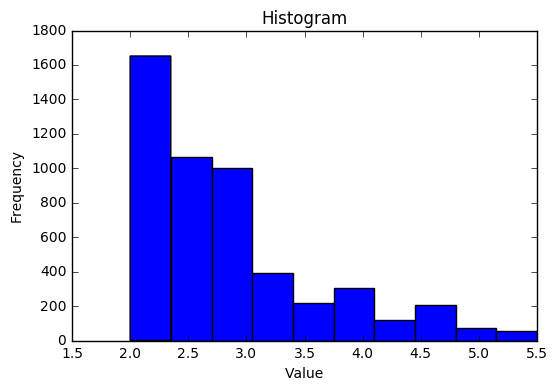

In [3]:
fig, ax = plt.subplots()
ax.hist(itis)
ax.set_title('Histogram')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
fig.show()
print('Mean ISI is {0}'.format(np.mean(itis)))